# 3D Deconvolution

In this notebook, we will perform Richardson-Lucy (RL) deconvolution on a 3D dataset with PyImageJ and `imagej-ops`. To learn more about deconvolution please visit the [RL deconvolution wikipedia](https://en.wikipedia.org/wiki/Richardson%E2%80%93Lucy_deconvolution) page and the imagej.net wiki page on [deconvolution](https://imagej.net/imaging/deconvolution). 

This example uses a 3D image (shape: `(200, 200, 61)`) of a HeLa cell nucleus stained with DAPI  (4′,6-diamidino-2-phenylindole) and imaged on an epifluorescent microscope at 100x. Although the `imagej-ops` framework implements the standard RL algorithm, this notebook utilizes the Richardson-Lucy Total Variation (RLTV) algorithm, which uses regularization to limit the noise amplified by the RL algorithm<sup>1</sup>.

## Richardson-Lucy Total Variation Deconvolution with ImageJ2 and imagej-ops

While it's not necessary to specify `add_legacy=False` for this workflow  (initializing imagej with `ij = imagej.init()` works equally as well), legacy is disabled here to demonstrate that this workflow only needs `imagej2` and the `imagej-ops` framework.

Let's start by first initializing ImageJ2 and setting our deconvolution parameters.

In [1]:
import imagej
import matplotlib.pyplot as plt

ij = imagej.init(add_legacy=False)
print(f"ImageJ2 version: {ij.getVersion()}")

ImageJ2 version: 2.14.0


The next cell will set the parameters needed to generate the synthetic point spread function (PSF) we need to deconvolve the input image. These values are derived from your experimental parameters. For this dataset the needed values are:

| Parameter                    | Value          |
| :---:                        | :---:          |
| Numerical Aperture           | 1.45           |
| Emission Wavelength          | 457 nm         |
| Refractive index (immersion) | 1.5            |
| Refractive index (sample)    | 1.4            |
| Lateral resolution (XY)      | 0.065 μm/pixel |
| Axial resolution (z)         | 0.1 μm/pixel   |
| Particle position            | 0 μm           |

The _numerical aperture_ can be obtained from the objective used to image the sample, here `1.45`. The _emission wavelength_ is the emission wavelength imaged, in this case DAPI's peak emission wavelength is 457 nm. The _refractive index (immersion)_ and _refractive index (sample)_ are experimentally obtained, however some reasonable average values are `1.5` and `1.4` respectively. The _lateral resolution_ is the μm/pixel value for the given image. The _axial resolution_ is the μm/pixel value for the given image, often the "step size" of a Z acquisition. Lastly, _particle position_ is the distance from the coverslip for the position or point of focus (_e.g._ if you were imaging a fluorescent bead, the _particle position_ value is how far in μm the sample/bead is away from the coverslip).

In [2]:
iterations = 15
na = 1.45 # numerical aperture
wv = 457 # emission wavelength
ri_immersion = 1.5 # refractive index (immersion)
ri_sample = 1.4 # refractive index (sample)
lat_res = 0.065 # lateral resolution (i.e. xy)
ax_res = 0.1 # axial resolution (i.e. z)
pz = 0 # distance away from coverslip
reg = 0.002 # regularization factor for Richardson-Lucy TV (see Dey et al. 2006, PMID: 16586486)

Now, let's load the sample data and display slice `30`.

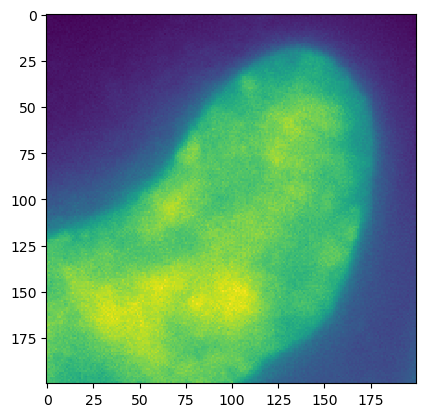

In [3]:
# open the 3D HeLa dataset
img = ij.io().open('https://media.imagej.net/workshops/data/3d/hela_nucleus.tif')

# display slice 30 of the dataset
ij.py.show(img[:, :, 30])

Here we can see a fuzzy slice of the HeLa nucleus. The next few cells will set up the needed components to run RLTV on the 3D datasets. The RLTV implementation in the `imagej-ops` framework requires four parameters: 

- input image (32-bit)
- point spread function (synthetic or real)
- iterations
- regularization factor

The _input image_ is the original image `img`. The _point spread function_ (PSF) can be either **real** (_i.e._ a collected PSF) or **synthetic**. This notebook will create a synthetic PSF using `imagej-ops`. _iterations_ is the number of times the data is deconvolved (_note:_ higher iteration values may introduce processing artifacts).

## Creating a synthetic PSF with the Gibson-Lanni model.

The `imagej-ops` framework can create a synthetic PSF using the Gibson-Lanni algorithm<sup>2</sup>. To create the synthetic PSF we need to use the `kernelDiffraction` op in the `create` namespace. Due to an existing known bug, we need to manually obtain the `create` namespace. See this [troubleshooting section](Troubleshooting.md#typeerror-no-matching-overloads) for more information. Before we can use the `kernelDiffraction` op we also need the `net.imglib2.FinalDimensions` Java class to create a set of imglib2 dimensions and the `net.imglib2.type.numeric.real.FloatType` Java class.

In [4]:
# import imagej2 and imglib2 Java classes
CreateNamespace = imagej.sj.jimport('net.imagej.ops.create.CreateNamespace')
FinalDimensions = imagej.sj.jimport('net.imglib2.FinalDimensions')
FloatType = imagej.sj.jimport('net.imglib2.type.numeric.real.FloatType')

The `kernelDiffraction` op accepts its parameters in meters and _not_ μm or nm. The following cell will convert in required parameters into meters.

In [5]:
# convert input parameters into meters
wv = wv * 1E-9
lat_res = lat_res * 1E-6
ax_res = ax_res * 1E-6
pz = pz * 1E-6

Finally, the `kernelDiffraction` requires `imglib2` dimensions, which is a Java object (`net.imglib2.FinalDimensions`), for the PSF. These dimensions are the same as the input image's dimensions and simply requires casting the image's shape with `FinalDimensions`.

In [6]:
# convert the input image dimensions to imglib2 FinalDimensions
psf_dims = FinalDimensions(img.shape)

Now with all the parameters set, we can create the PSF and display an axial and orthogonal side view.

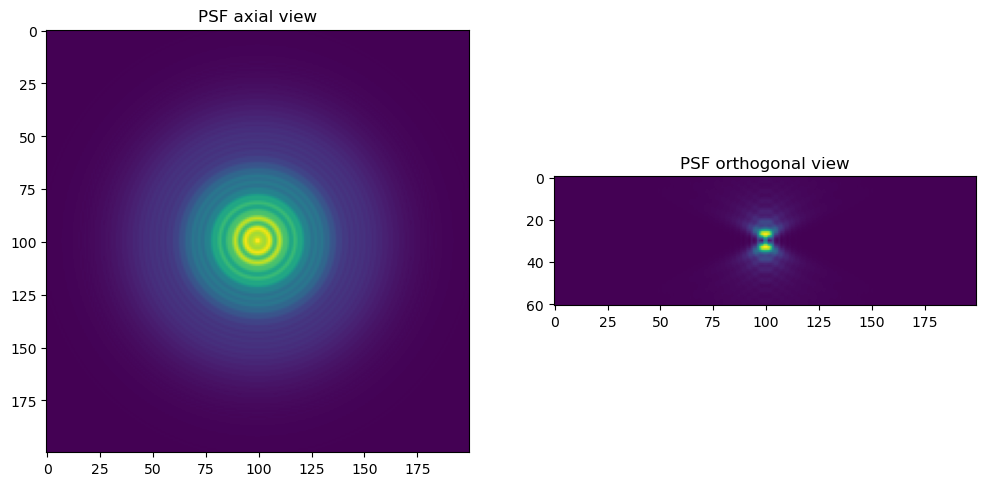

In [7]:
# create synthetic PSF
psf = ij.op().namespace(CreateNamespace).kernelDiffraction(psf_dims, na, wv, ri_sample, ri_immersion, lat_res, ax_res, pz, FloatType())

# convert PSF from Java to Python (numpy array)
psf_narr = ij.py.from_java(psf)

# display the axial and orthogonal side view of the PSF side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 9))
ax[0].imshow(psf_narr[5, :, :])
ax[0].set_title("PSF axial view")

# transpose the array to create an orthogonal side view
xz_psf_narr = psf_narr.transpose(1, 0, 2)
ax[1].imshow(xz_psf_narr[102, :, :])
ax[1].set_title("PSF orthogonal view")

# display plot
plt.show()

In [11]:
xz_psf_narr.shape

(200, 61, 200)

## Running the RTLV deconvolution op

With the synthetic PSF we can now deconvolve the input image. The RTLV works on 32-bit images, so before we can use the RLTV op we need to convert the input `img` to 32-bit.

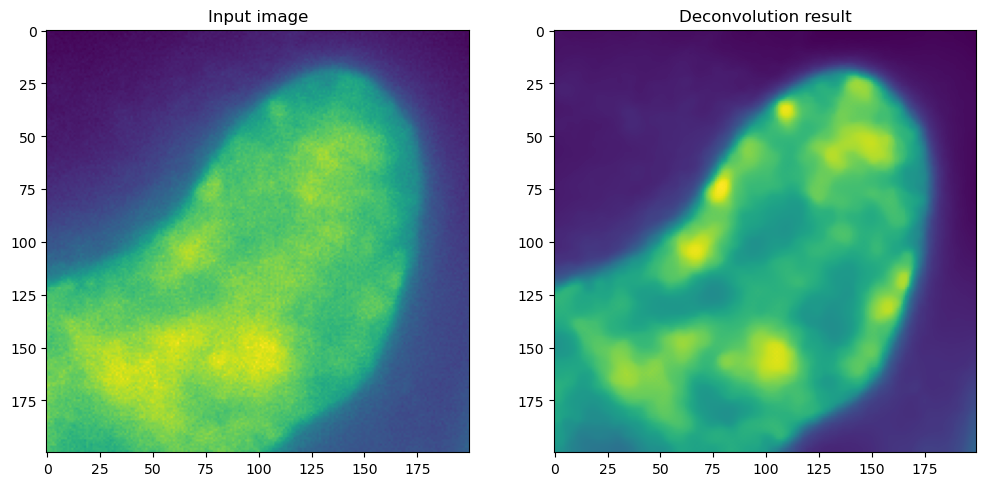

In [8]:
# convert input image to 32-bit and deconvolve with RTLV
img_f = ij.op().convert().float32(img)
img_decon = ij.op().deconvolve().richardsonLucyTV(img_f, psf, iterations, reg)

# display slice 30 of the input image and deconvolution result side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 9))
ax[0].imshow(ij.py.from_java(img[:, :, 30]))
ax[0].set_title("Input image")
ax[1].imshow(ij.py.from_java(img_decon[:, :, 30]))
ax[1].set_title("Deconvolution result")

# display plot
plt.show()

## References

<sup>1</sup>: [Dey _et. al_, _Micros Res Tech_ 2006](https://pubmed.ncbi.nlm.nih.gov/16586486/)</br>
<sup>2</sup>: [Gibson & Lani, _JOSA_ 1992](https://pubmed.ncbi.nlm.nih.gov/1738047/)